# Introduction

In my analysis, I will be exploring the following:

- Based on the reviews of the last year, what makes a good user experience at a Airbnb rental? What makes a poor user experience? What would you advise to new Airbnb hosts to ensure high reviews and consistent renters?
- What are some of the seasonal Airbnb trends you've noticed in the San Francisco area? When are the down months over the last year? Which months are the most busy? Which areas were the most popular during these times? How have prices changed over time?
- Are airbnb's that are available for monthly rent competitive with the local markets?
- Can you create a price predictor for listings price? What features allows renters to charge more?

In [2]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Set pandas backend to create interactive plots
#pd.options.plotting.backend = 'hvplot'

#Whats the defailt back end? Not all plots work with this

In [5]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#Ignore warnings
import warnings; warnings.simplefilter('ignore')

**Read in Data**

In [6]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

In [7]:
#Read in Zillow data
zillow = pd.read_csv(path + '12_29_2019_Zillow_Cleaned.csv', index_col=0, sep=',')

#Read in Airbnb Listings Data
listings = pd.read_csv(path + '12_27_2019_Listings_Cleaned.csv',index_col=0, low_memory=False, sep=',')

#Parse dates
parse_dates = ['date']

#Read in Airbnb Calendar and Reviews data
calendar = pd.read_csv(path + '12_23_2019_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=parse_dates,index_col=0, low_memory=False)

reviews = pd.read_csv(path + '12_24_2019_Reviews_Cleaned.csv', sep=',',
                      parse_dates=parse_dates,index_col=0)


# Data Preview

**Airbnb Listings Data**

In [8]:
#Preview listings data
display(listings.head())

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,maximum_maximum_nights,name,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,space,summary,transit,zipcode,weekly_price,monthly_price
0,3,TV Cable TV Internet Wifi Kitchen Pets liv...,0,77,1,Real Bed,1,2,1,0,0,2019-04-03 00:00:00.000000,NaN,moderate,San Francisco,100,New update: the house next door is under const...,25,2009-07-23 00:00:00.000000,2,We are a family with 2 boys born in 2009 and 2...,True,1169,True,True,1,"San Francisco, California, United States",Holly,Duboce Triangle,100,within an hour,2008-07-31 00:00:00.000000,email phone facebook reviews kba,* No Pets - even visiting guests for a short t...,958,True,True,2019-03-16 00:00:00.000000,38,-122,30,"Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,183,51,170,Apartment,False,False,True,10,10,10,10,10,97,10,2,Entire home/apt,20190403130253,100,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,94117,1120,4200
1,5,Internet Wifi Kitchen Heating Family/kid fri...,0,0,1,Real Bed,2,3,1,0,0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,100,We live in a large Victorian house on a quiet ...,0,2009-05-03 00:00:00.000000,2,Philip: English transplant to the Bay Area and...,True,8904,True,False,2,"San Francisco, California, United States",Philip And Tania,Bernal Heights,80,within a day,2009-03-02 00:00:00.000000,email phone reviews kba work_ema...,"Please respect the house, the art work, the fu...",5858,False,True,2017-08-06 00:00:00.000000,38,-122,60,Creative Sanctuary,I love how our neighborhood feels quiet but is...,Bernal Heights,111,0,235,Apartment,False,False,True,10,10,10,10,10,98,9,1,Entire home/apt,20190403130253,nan,We live in a large Victorian house on a quiet ...,NaN,The train is two blocks away and you can stop ...,94110,1600,5500
2,2,TV Internet Wifi Kitchen Free street parking...,30,365,4,Real Bed,1,1,9,9,0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,50,Nice and good public transportation. 7 minute...,12,2009-08-31 00:00:00.000000,1,7 minutes walk to UCSF. 15 minutes walk to US...,True,21994,True,False,10,"San Francisco, California, United States",Aaron,Cole Valley,100,within a few hours,2009-06-17 00:00:00.000000,email phone reviews jumio govern...,"No party, No smoking, not for any kinds of smo...",7918,False,True,2016-11-21 00:00:00.000000,38,-122,60,A Friendly Room - UCSF/USF - San Francisco,"Shopping old town, restaurants, McDonald, Whol...",Haight Ashbury,17,0,65,Apartment,False,False,True,8,9,8,9,9,85,8,0,Private room,20190403130253,200,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,94117,485,1685
3,2,TV Internet Wifi Kitchen Free street parking...,30,365,4,Real Bed,1,1,9,9,0,2019-04-03 00:00:00.000000,NaN,strict_14_with_grace_period,San Francisco,50,Nice and good public transportation. 7 m

**Airbnb Reviews Data**

In [9]:
#Preview reviews data
display(reviews.head())

,comments,date,id,listing_id,reviewer_id,reviewer_name
19330,...,2013-12-01,9000494,209514,9215434,Ramon
143113,Stop and book it now Rea Website hidd...,2017-06-07,158659946,4833101,35954713,Tim
3597188,So I moved to SF in late May from Mich...,2013-06-02,4928809,635850,6542011,Michael
64636,This was the perfect home from home ou...,2014-10-16,21374058,1150867,13431837,Chris & Tess
174143,We loved our time in beautiful SF The p...,2018-08-10,305042501,7226841,73281468,Jessica ( + Mark)


**Airbnb Calendar Data**

In [10]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,80,0,2019-04-03,187730,120,3,80
1,80,0,2019-04-04,187730,120,3,80
2,82,1,2019-04-05,187730,120,3,82
3,82,1,2019-04-06,187730,120,3,82
4,81,1,2019-04-07,187730,120,3,81


**Zillow Data**

In [11]:
#Preview zillow data
display(zillow.head())

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Date,Median_Rent
4928,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-03,1200
11368,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-04,1250
17808,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-05,1200
24248,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-06,1250
30688,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-07,1225


For this analysis, we will isolate the rows in our Zillow data that are in the zipcode or city of the listings data.

In [12]:
#Capture zip information from listings
listings_zip = list(listings.zipcode.unique())

#Capture city information from listings 
listings_cities = list(listings.city.unique())

#Capture SF Data
sf_zillow = zillow[zillow['Zip'].isin(listings_zip) | zillow['City'].isin(listings_cities)]

#Check
print(sf_zillow.shape)
display(sf_zillow.head())

(2074, 9)


,City,County,Metro,Zip,State,SizeRank,Bedrooms,Date,Median_Rent
116561,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94109,CA,12,1,2011-09,2472
117191,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94107,CA,642,1,2011-09,3185
123001,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94109,CA,12,1,2011-10,2400
123631,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94107,CA,642,1,2011-10,3175
125588,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94107,CA,923,2,2011-10,4500


# Data Exploration

- How has Airbnb grown over the last year? What times of year are there more bookings and in which neighborhoods?
- What are the metrics for the different neighborhoods in SF?
- Are airbnb's that are available for monthly rent competitive with the local rent market? Is Airbnb a legitmate option to consider for short term living as opposed to finding month to month leases?
- What are the different data distributions for the different outcome variables we are interested in exploring?



#### What are the different data distributions for the different outcome variables we are interested in exploring?


#### How has Airbnb grown over the last year(11/2018 - 10/2019)?

Let's begin by taking a look at the number of unique listings per month available for rent from Airbnb hosts.

In [29]:
#Convert date to month year and add to calendar
calendar['month_year'] = pd.to_datetime(calendar['date']).dt.to_period('M')

#Filter calendar to show listings from nov 2018 - oct 2019 and store in a df
last_year=calendar[(calendar['date'] < '2019-11-01')]

#Group last year by month_year and get a count of unique listings per month
last_year = last_year.groupby(['month_year'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
last_year =last_year.rename(columns = {'nunique': 'listings'})

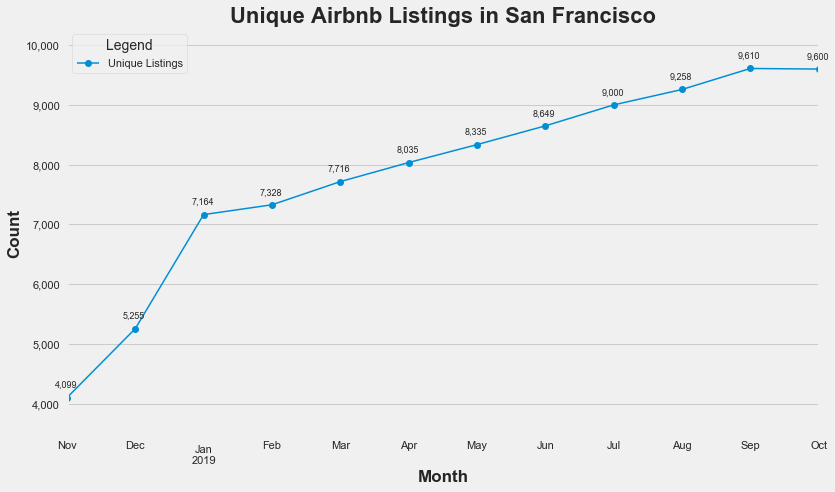

In [66]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Plot data
ax = last_year.plot(x='month_year', y='listings', kind = 'line',style='o-', markersize=7,
          title='Unique Airbnb Listings in San Francisco', label= 'Unique Listings',
         linewidth = 1.5, figsize = (12,7))

#Set fontdict
fontdict={'weight' : 'bold',
          'size': 17}

#Set x and y labels
ax.set_xlabel('Month',fontdict=fontdict)
ax.set_ylabel('Count', fontdict=fontdict)

#Format yticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

#Set Title
ax.set_title('Unique Airbnb Listings in San Francisco', fontweight = 'bold', fontsize=22)

#Adjust plot margins
ax.margins(0,.12)

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Add Text
xs,ys=last_year['month_year'], last_year['listings']

for x,y in zip(xs,ys):
    label = '{:,}'.format(y)
    plt.annotate(label, (x,y),textcoords="offset points",fontsize = 9, xytext=(10,10), ha='right')

#Set legend
plt.legend(title='Legend', frameon = True, loc='upper left');

Over the last year, there has been significant growth in the number of listings available for rent month to month. Let us look into the number of nights booked by users over the last year.

In [67]:
#Capture counts of availability/unavailability of each listing per month
availability = calendar.groupby(['available', 'month_year', 'listing_id'])['listing_id'].agg({'count'}).reset_index()
availability

#first
#availability = calendar.groupby(['month_year', 'listing_id', 'available'])['listing_id'].agg({'count'}).reset_index()

,available,month_year,listing_id,count
0,0,2019-01,958,23
1,0,2019-01,8567,23
2,0,2019-01,8739,18
3,0,2019-01,9225,4
4,0,2019-01,10251,14
...,...,...,...,...
264116,1,2020-09,38505485,10
264117,1,2020-09,38512785,10
264118,1,2020-09,38519121,10
264119,1,2020-09,38526194,10


In [69]:
table = pd.pivot_table(availability, values = 'count', index=['month_year'], columns=['available'], aggfunc=np.sum)
table.head()

available,0,1
month_year,,
2018-11,nan,58021
2018-12,nan,130516
2019-01,100335,208866
2019-02,154209,252198
2019-03,192391,324519


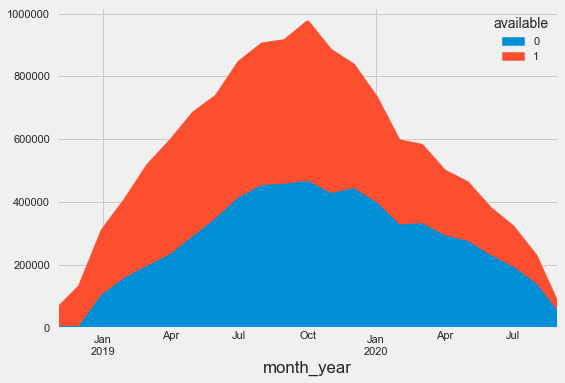

In [17]:

table.plot.area()

In [18]:
#Filter availability to show listings from nov 2018 - oct 2019 and store in a df
availability=availability[(availability['month_year'] < '2019-11')]

#Isolate counts of available listings
available = availability[availability.available == 1]

#Isolate counts of unavailable listings
unavailable = availability[availability.available == 0]

In [19]:
available=available.groupby(['month_year'])['count'].sum().reset_index()

#available = available[available.month_year > '2018-12']

available

,month_year,count
0,2018-11,58021
1,2018-12,130516
2,2019-01,208866
3,2019-02,252198
4,2019-03,324519
5,2019-04,366060
6,2019-05,396951
7,2019-06,393261
8,2019-07,435093
9,2019-08,452954


In [20]:
unavailable = unavailable.groupby(['month_year'])['count'].sum().reset_index()

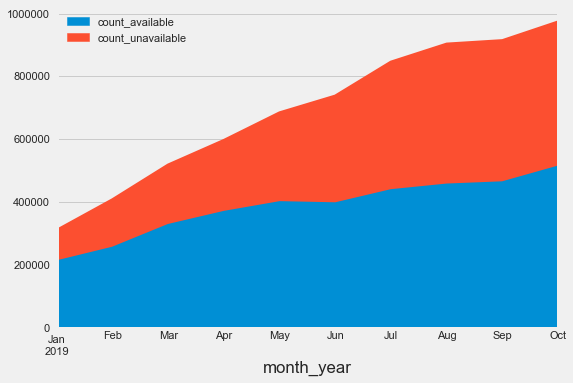

In [21]:
#change the backend on this to see aggragate
test = available.merge(unavailable,left_on=  'month_year', right_on='month_year', suffixes=('_available', '_unavailable')).set_index('month_year')


test.plot.area()

* Comparing monthly rent of airbnb to zillow

In [22]:
monthly_airbnb = listings[-listings.monthly_price.isnull()]

monthly_airbnb.groupby('bedrooms')['monthly_price'].median().reset_index()

,bedrooms,monthly_price
0,0,3500
1,1,3000
2,2,5145
3,3,5950
4,4,4500
5,5,10500


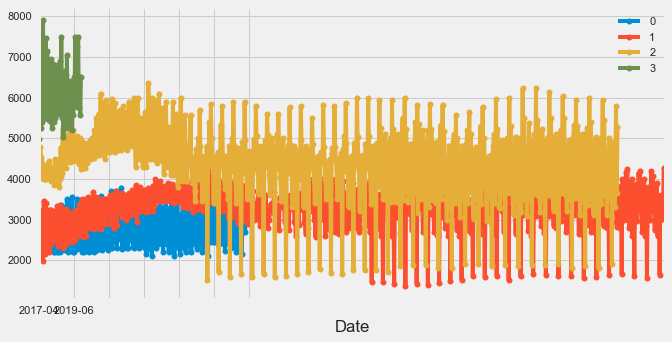

In [23]:
#test = sf_zillow.groupby(['Bedrooms', 'Date'])['Median_Rent'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,5))

sf_zillow.groupby("Bedrooms").plot(x="Date", y="Median_Rent", marker="o", ax=ax)
ax.legend([0,1,2,3])

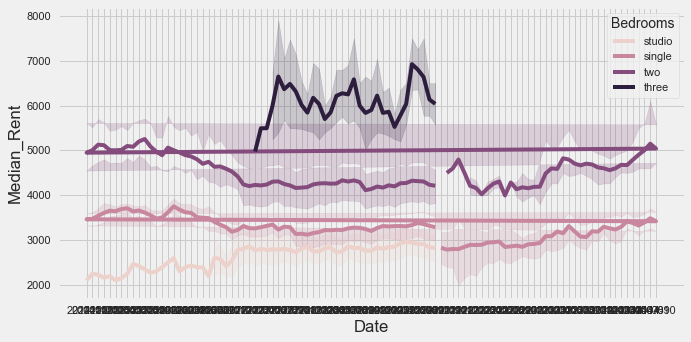

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x = 'Date', y ='Median_Rent', hue = 'Bedrooms', data = sf_zillow, ax=ax)

plt.legend(title='Bedrooms', frameon = True, loc='upper right', labels=['studio', 'single','two','three'])


* Geo spatial map of price averages for a night/week/month by neighborhood(11/2018 vs 10/2019)

**Prices by property type**


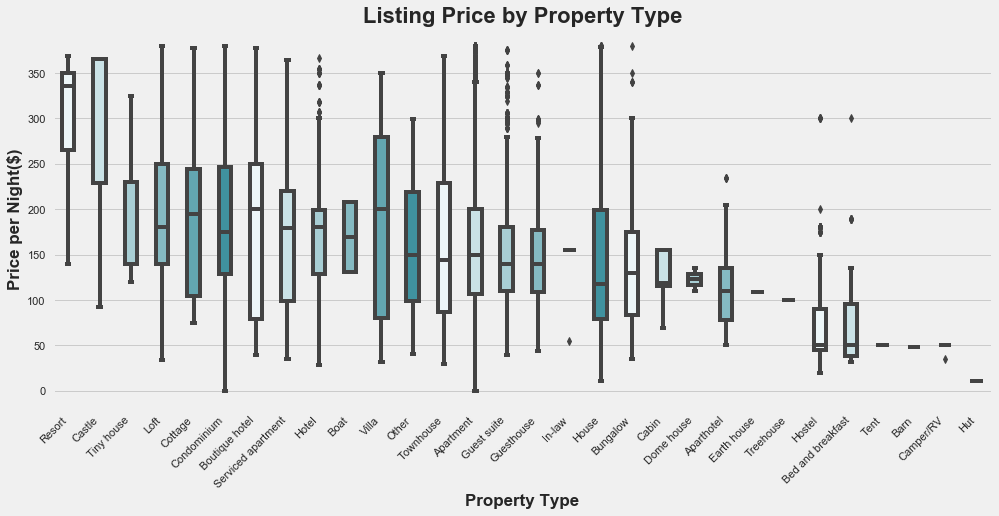

In [25]:

test = listings.groupby('property_type')['price'].mean().sort_values(ascending = False).reset_index()
test_list = test.property_type.tolist()

#Set 538 plot style
plt.style.use('fivethirtyeight')

#Set Figure
f, ax = plt.subplots(figsize= (15,6.5))

#Plot
g= sns.boxplot(x="property_type", y="price", order=test_list, 
               width = .4,palette=sns.light_palette((210, 90, 60), input="husl"),
             data=listings, ax=ax)

#Set Title
ax.set_title('Listing Price by Property Type', fontweight = 'bold', fontsize=22)

#Set x and y Labels
ax.set_ylabel('Price per Night($)',fontdict=fontdict)
ax.set_xlabel('Property Type',fontdict=fontdict)

#Rotate x_ticklabels
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

#Format ticks on y-axis

**Average prices by neighborhood**

Text(0, 0.5, 'test')

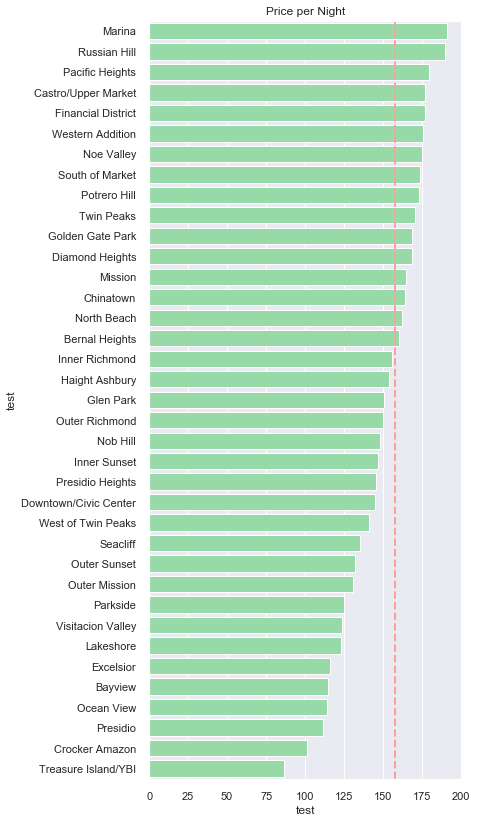

In [26]:
#Set plot aesthetics for notebook
sns.set(style='darkgrid', palette='pastel', color_codes=True)

#Create df to plot average price by neighborhood
neighborhood = listings.groupby(
    'neighbourhood_cleansed')['price'].mean().reset_index().sort_values(
                                            by='price', ascending=False)

#Set fig dimensions
f, ax = plt.subplots(figsize= (5,13))

#plot
g= sns.barplot(x='price', y='neighbourhood_cleansed', color='g',
              data=neighborhood, ax=ax)

#Set plot Title
g.set_title('Price per Night')

#Add mean
mean = listings.price.mean()
plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

#Set plot labels
g.set_xlabel('test')
g.set_ylabel('test')

Prices accross San Francisco

In [27]:
# neighborhood.plot(kind='scatter', x="longitude", y="latitude",c='price', 
#           cmap=plt.get_cmap("jet"),label = 'Price', 
#     colorbar=True, alpha=0.8, figsize=(10,10))
# plt.legend()
# plt.show()


**Heat map**

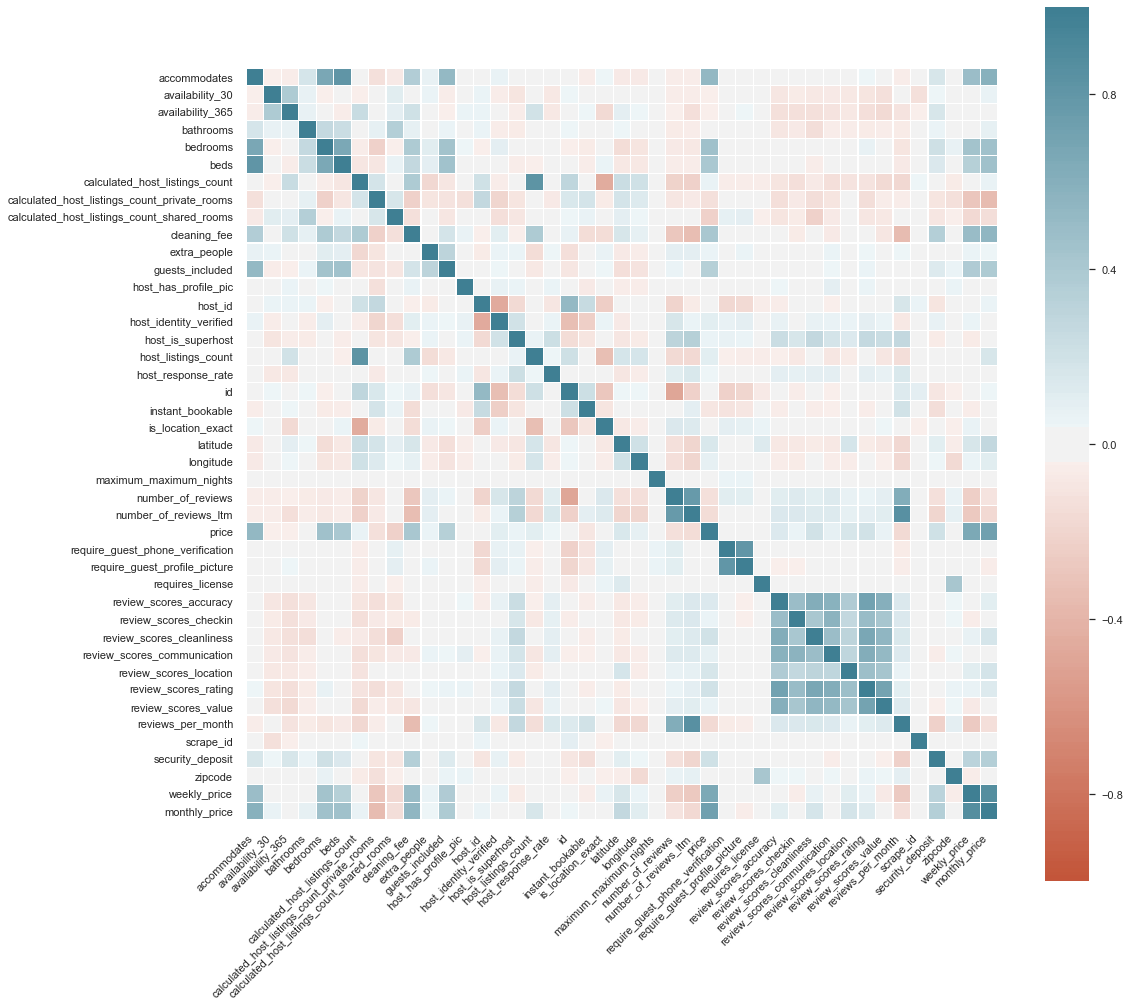

In [28]:
corr = listings.corr()
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,linewidths=.1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Principal Component Analysis